In [2]:
import re,time
import  matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import Counter
# plt.rcParams['font.sans-serif']=['SimHei']
# plt.rcParams['axes.unicode_minus'] = False
from numpy.linalg import norm    #范数




# data_process

In [3]:
path=r'.\input\snippets1\snippets1_gsdmm.xlsx'
data_initial=pd.read_excel(path)


vocab_max_size=10000   
vocab_min_count=2
data=data_initial['new_nltk'].values.tolist()
data_matrix=[text.split()  for text in data]
data=[ele for row in data_matrix for ele in row]

vocab =Counter(data)
vocab_arr = [[wd, vocab[wd]] for wd in vocab if vocab[wd] >vocab_min_count] 
vocab_arr = sorted(vocab_arr, key=lambda k: k[1])[::-1]   
vocab_arr = sorted(vocab_arr)              
vocab2id = {value[0]:itm for itm,value in enumerate(vocab_arr)}

#text-word
doc_word_matrix=[]
for row in data_matrix:
    temp_row=[]
    for word in row:
        if word in vocab2id:
            temp_row.append(vocab2id[word])
    doc_word_matrix.append(temp_row)

#text-word
doc_word_matrix1=[]
for row in data_matrix:
    temp_row=[]
    for word in row:
        if word in vocab2id:
            temp_row.append(word)
    doc_word_matrix1.append(temp_row)  
    

#insert tag
# data_initial.insert(3, 'tag',list(range(n_docs)))
doc_word_matrix2=[' '.join(doc)for doc in doc_word_matrix1]
data_initial.insert(3, 'doc_word',doc_word_matrix2)
doc_word_matrix3=list(zip(range(len(doc_word_matrix2)),doc_word_matrix2 ))

# k-means

In [4]:
from sklearn.cluster import KMeans
def kmeans(matrix,topic):
    kmeans = KMeans(n_clusters=topic, random_state=42).fit(matrix)
    kmeans_pred=kmeans.labels_
    return kmeans_pred





# NMF、SeaNMF

In [5]:

class SeaNMF(object):
    def __init__(
        self,
        A, S,     # A 为 文档--词矩阵,S为SPPMI矩阵
        IW1=[], IW2=[], IH=[],
        alpha=1.0, beta=0.1, n_topic=10, max_iter=100, max_err=1e-3, 
        rand_init=True, fix_seed=False):
        
        
        # 损失函数==目标函数
        '''
        0.5*||A-WH^T||_F^2+0.5*alpha*||S-WW_c^T||_F^2+0.5*beta*||W||_1^2
        W = W1
        Wc = W2
        '''
        if fix_seed: 
            np.random.seed(0)
            
        self.obj=[] #记录损失值
        
        self.A = A   #原始矩阵
        self.S = S   #SPPMI矩阵
        self.n_row = A.shape[0]
        self.n_col = A.shape[1]
        self.n_topic = n_topic
        self.max_iter = max_iter
        self.alpha = alpha
        self.beta = beta
        self.B = np.ones([self.n_topic,1])  # 10*1的矩阵
        self.max_err = max_err 

        if rand_init:
            self.nmf_init_rand()
        else:
            self.nmf_init(IW1, IW2, IH)
        self.nmf_iter()

    # W1,W2每一列进行标准化处理
    def nmf_init_rand(self):
        self.W1 = np.random.random((self.n_row, self.n_topic))
        self.W2 = np.random.random((self.n_row, self.n_topic))
        self.H = np.random.random((self.n_col, self.n_topic))
        # print(self.W1.shape,self.W2.shape,self.H.shape,self.A.shape)

        for k in range(self.n_topic):
            self.W1[:, k] /= norm(self.W1[:, k])    # np.linalg.norm
            self.W2[:, k] /= norm(self.W2[:, k])
            
    #更新W1,W2,H,标准化
    def nmf_init(self, IW1, IW2, IH):
        self.W1 = IW1
        self.W2 = IW2
        self.H = IH

        for k in range(self.n_topic):
            self.W1[:, k] /= norm(self.W1[:, k])
            self.W2[:, k] /= norm(self.W2[:, k])

    #迭代开始
    def nmf_iter(self):
        loss_old = 1e20
        # print('loop begin')
        start_time = time.time()
        for i in range(self.max_iter):
            self.nmf_solver()  #权值更新
            loss = self.nmf_loss()  #计算损失
#             print(i,' ',loss)
            self.obj.append(loss)
            if loss_old-loss < self.max_err:  #  0.001
                break
            loss_old = loss
            end_time = time.time()
            # print('Step={}, Loss={}, Time={}s'.format(i, loss, end_time-start_time))
            
#     W1,W2,H 的更新
    def nmf_solver(self):
        '''
        using BCD framework
        '''
        epss = 1e-20
        # Update W1
        AH = np.dot(self.A, self.H)  
        SW2 = np.dot(self.S, self.W2)  
        HtH = np.dot(self.H.T, self.H) 
        W2tW2 = np.dot(self.W2.T, self.W2)
        W11 = self.W1.dot(self.B)
#         print(sum(AH),sum(SW2),sum(HtH),sum(W2tW2),sum(W11))
        for k in range(self.n_topic):
            num0 = HtH[k,k]*self.W1[:,k] + self.alpha*W2tW2[k,k]*self.W1[:,k]
            num1 = AH[:,k] + self.alpha*SW2[:,k]
            num2 = np.dot(self.W1, HtH[:,k]) + self.alpha*np.dot(self.W1, W2tW2[:,k]) + self.beta*W11[0]
#             print('---------',num2.shape,W11.shape,W11[0].shape)
            self.W1[:,k] = num0 + num1 - num2
            self.W1[:,k] = np.maximum(self.W1[:,k], epss) # project > 0
            self.W1[:,k] /= norm(self.W1[:,k]) + epss # normalize
            
            
        # Update W2
        W1tW1 = self.W1.T.dot(self.W1)
        StW1 = np.dot(self.S, self.W1)
        for k in range(self.n_topic):
            self.W2[:,k] = self.W2[:,k] + StW1[:,k] - np.dot(self.W2, W1tW1[:,k])
            self.W2[:,k] = np.maximum(self.W2[:,k], epss)
        #Update H
        AtW1 = np.dot(self.A.T, self.W1)
        for k in range(self.n_topic):
            self.H[:,k] = self.H[:,k] + AtW1[:,k] - np.dot(self.H, W1tW1[:,k])
            self.H[:,k] = np.maximum(self.H[:,k], epss) 
            
            

    #计算损失
    def nmf_loss(self):
        '''
        Calculate loss
        '''
        loss = norm(self.A - np.dot(self.W1, np.transpose(self.H)), 'fro')**2/2.0
        if self.alpha > 0:
            loss += self.alpha*norm(np.dot(self.W1, np.transpose(self.W2))-self.S, 'fro')**2/2.0
        if self.beta > 0:
            loss += self.beta*norm(self.W1, 1)**2/2.0
            
        return loss
    def return_loss(self):
        return self.obj
    
    def return_weight(self):
        return self.W1, self.W2, self.H
    
        
        
        
'''
Topic Modeling via NMF
'''
class NMF(object):   
    def __init__(
        self, 
        A, n_topic,IW=[], IH=[],
         max_iter=100, max_err=1e-3,
        rand_init=True):
        '''
        A = WH^T
        '''
        self.A = A   #  input
        self.n_row = A.shape[0]
        self.n_col = A.shape[1]
        self.n_topic = n_topic
        self.max_iter = max_iter
        self.max_err = max_err

        self.obj = []
        if rand_init:
            self.nmf_init_rand()
        else:
            self.nmf_init(IW, IH)
        self.nmf_iter()
    
    #初始化标准化
    def nmf_init_rand(self):
        self.W = np.random.random((self.n_row, self.n_topic))
        self.H = np.random.random((self.n_col, self.n_topic))

        # print('nmf_init_rand')
        for k in range(self.n_topic):
            self.W[:,k] /= norm(self.W[:,k])
        # print(self.W.shape,self.H.shape)
    #标准化
    def nmf_init(self, IW, IH):
        self.W = IW
        self.H = IH
        # print('nmf_init')
        # for k in range(self.n_topic):
        #     self.W[:,k] /= norm(self.W[:,k])
    def nmf_iter(self):
        loss_old = 1e20
        start_time = time.time()         
        for i in range(self.max_iter):
            self.nmf_solver()     #更新权值
            loss = self.nmf_loss()   #查看损失
            self.obj.append(loss)
            if loss_old-loss < self.max_err:
                break
            loss_old = loss
            end_time = time.time()
            # print('iter:{}, loss:{}, time{}s'.format(i, round(loss,5), end_time-start_time))            
    def nmf_solver(self):
        '''
        regular NMF without constraint.
        Block Coordinate Decent
        '''
        epss = 1e-20       
        #使用块坐标下降法（BCD）更新参数        
        HtH = self.H.T.dot(self.H) 
        AH = self.A.dot(self.H)  
#         H:(15001, 10) A:(2443, 15001) HTH(10, 10) AH:(2443, 10) W:(2443, 10)
#         print(f'H:{self.H.shape} A:{self.A.shape} HTH{HtH.shape} AH:{AH.shape} W:{self.W.shape}')
        for k in range(self.n_topic):
            tmpW = self.W[:,k]*HtH[k,k] + AH[:,k] - np.dot(self.W, HtH[:,k])
            self.W[:,k] = np.maximum(tmpW, epss)
            self.W[:,k] /= norm(self.W[:,k]) + epss
        WtW = self.W.T.dot(self.W)
        AtW = self.A.T.dot(self.W)
        for k in range(self.n_topic):
            self.H[:,k] = self.H[:,k]*WtW[k,k] + AtW[:,k] - np.dot(self.H, WtW[:,k])
            self.H[:,k] = np.maximum(self.H[:,k], epss)
    def nmf_loss(self):
        loss = norm(self.A - np.dot(self.W, self.H.T), 'fro')**2/2.0
        return loss 
    def get_loss(self):
        return np.array(self.obj) 
    def return_weight(self):
        return self.W,self.H

def nmf(matrix,topic):
    model = NMF(
        matrix.T, 
        n_topic=topic
       )
    model.nmf_iter()
    W,H=model.return_weight()
    nmf_pred=np.zeros(H.shape[0])
    for index,value in enumerate(H):
        nmf_pred[index]=list(value).index(np.max(value))
    return nmf_pred


def seanmf(matrix,topic,pmi):
    model = SeaNMF(
        matrix.T, pmi,
        n_topic=topic)
    W1,W2,H=model.return_weight()
    seanmf_pred=np.zeros(H.shape[0])
    for index,value in enumerate(H):
        seanmf_pred[index]=list(value).index(np.max(value))
    return seanmf_pred

# LDA

In [6]:
from sklearn.decomposition import LatentDirichletAllocation as LDA

def lda(matrix,topic):
    lda=LDA(n_components=topic, 
             max_iter=50,
             learning_method='batch',    
             learning_offset=50,
             random_state=0)
    lda.fit(matrix)
    topics=lda.transform(matrix)  #文本-主题矩阵
    lda_pred=[]
    for i in topics:
        lda_pred.append(list(i).index(np.max(i)))  #获取列表最大值的索引
    return lda_pred


# GSDMM

In [4]:
#gsdmm
from numpy.random import multinomial
from numpy import log, exp
from numpy import argmax
import json

class MovieGroupProcess:
    def __init__(self, K=8, alpha=0.1, beta=0.1, n_iters=30):
        '''
        Reference: http://dbgroup.cs.tsinghua.edu.cn/wangjy/papers/KDD14-GSDMM.pdf
        
        :param K: int
            Upper bound on the number of possible clusters. Typically many fewer
        :param alpha: float between 0 and 1
            Alpha controls the probability that a student will join a table that is currently empty
            When alpha is 0, no one will join an empty table.
        :param beta: float between 0 and 1
            Beta controls the student's affinity for other students with similar interests. A low beta means
            that students desire to sit with students of similar interests. A high beta means they are less
            concerned with affinity and are more influenced by the popularity of a table
        :param n_iters:
        '''
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.n_iters = n_iters

        # slots for computed variables
        self.number_docs = None
        self.vocab_size = None
        self.cluster_doc_count = [0 for _ in range(K)]
        self.cluster_word_count = [0 for _ in range(K)]
        self.cluster_word_distribution = [{} for i in range(K)]

    @staticmethod
    def _sample(p):
        '''
        Sample with probability vector p from a multinomial distribution
        :param p: list
            List of probabilities representing probability vector for the multinomial distribution
        :return: int
            index of randomly selected output
        '''
        return [i for i, entry in enumerate(multinomial(1, p)) if entry != 0][0]

    def fit(self, docs, vocab_size):
        '''
        Cluster the input documents
        :param docs: list of list
            list of lists containing the unique token set of each document
        :param V: total vocabulary size for each document
        :return: list of length len(doc)
            cluster label for each document
        '''
        alpha, beta, K, n_iters, V = self.alpha, self.beta, self.K, self.n_iters, vocab_size

        D = len(docs)
        self.number_docs = D
        self.vocab_size = vocab_size

        # unpack to easy var names
        # mz number of documents in cluster z 
        # nz number of words in cluster z   
        # nwz number of occurrences of word w in cluster z  
        m_z, n_z, n_z_w = self.cluster_doc_count, self.cluster_word_count, self.cluster_word_distribution
        cluster_count = K

        d_z = [None for i in range(len(docs))]
        
        # initialize the clusters

        for i, doc in enumerate(docs):
            # choose a random  initial cluster for the doc
            z = self._sample([1.0 / K for _ in range(K)])
            d_z[i] = z  
            m_z[z] += 1  
            n_z[z] += len(doc)
            
            for word in doc:
                if word not in n_z_w[z]:
                    n_z_w[z][word] = 0  
                n_z_w[z][word] += 1   
        # print(n_z_w[0])
        # print(n_z[0])
        for _iter in range(n_iters):
            total_transfers = 0
            for i, doc in enumerate(docs):
                
                # remove the doc from it's current cluster
                z_old = d_z[i]
                m_z[z_old] -= 1 
                n_z[z_old] -= len(doc)
                for word in doc:

                    n_z_w[z_old][word] -= 1   
                    # compact dictionary to save space
                    if n_z_w[z_old][word] == 0:  
                        del n_z_w[z_old][word]

                # draw sample from distribution to find new cluster
                p = self.score(doc)
                z_new = self._sample(p)  

                # transfer doc to the new cluster
                if z_new != z_old:
                    total_transfers += 1
                #先减后加
                d_z[i] = z_new
                m_z[z_new] += 1
                n_z[z_new] += len(doc)
                for word in doc:
                    if word not in n_z_w[z_new]:
                        n_z_w[z_new][word] = 0
                    n_z_w[z_new][word] += 1

            cluster_count_new = sum([1 for v in m_z if v > 0])
            print("In stage %d: transferred %d clusters with %d clusters populated" % (_iter, total_transfers, cluster_count_new))
            if total_transfers == 0 and cluster_count_new == cluster_count and _iter>25:
                print("Converged.  Breaking out.")
                break
            cluster_count = cluster_count_new
        self.cluster_word_distribution = n_z_w
        return d_z

    def score(self, doc):
        '''
        Score a document

        Implements formula (3) of Yin and Wang 2014.
        http://dbgroup.cs.tsinghua.edu.cn/wangjy/papers/KDD14-GSDMM.pdf

        :param doc: list[str]: The doc token stream
        :return: list[float]: A length K probability vector where each component represents
                              the probability of the document appearing in a particular cluster
        '''
        alpha, beta, K, V, D = self.alpha, self.beta, self.K, self.vocab_size, self.number_docs
        m_z, n_z, n_z_w = self.cluster_doc_count, self.cluster_word_count, self.cluster_word_distribution
        p = [0 for _ in range(K)]
        #  We break the formula into the following pieces
        #  p = N1*N2/(D1*D2) = exp(lN1 - lD1 + lN2 - lD2)
        #  lN1 = log(m_z[z] + alpha)
        #  lN2 = log(D - 1 + K*alpha)
        #  lN2 = log(product(n_z_w[w] + beta)) = sum(log(n_z_w[w] + beta))
        #  lD2 = log(product(n_z[d] + V*beta + i -1)) = sum(log(n_z[d] + V*beta + i -1))

        lD1 = log(D - 1 + K * alpha)
        doc_size = len(doc)
        for label in range(K):   
            lN1 = log(m_z[label] + alpha)  
            lN2 = 0
            lD2 = 0
            for word in doc:
                lN2 += log(n_z_w[label].get(word, 0) + beta) 
            for j in range(1, doc_size +1):
                lD2 += log(n_z[label] + V * beta + j - 1)     
            p[label] = exp(lN1 - lD1 + lN2 - lD2)

        # normalize the probability vector
        pnorm = sum(p)
        pnorm = pnorm if pnorm>0 else 1
        return [pp/pnorm for pp in p]

    def choose_best_label(self, doc):
        '''
        Choose the highest probability label for the input document
        :param doc: list[str]: The doc token stream
        :return:
        '''
        p = self.score(doc)
        return argmax(p),max(p)
def gsdmm(matrix,topic,n_terms):
    model= MovieGroupProcess(K=topic, alpha=0.1, beta=0.1, n_iters=15)
    gsdmm_pred= model.fit(matrix, n_terms)
    return gsdmm_pred

# Stability

In [5]:
import random
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

# extract the top n ranked words of each topics,the initialized R0,
def the_ranking_set_R0(topic,num_words):
    global data_initial
    data_temp=data_initial[['doc_word',topic]]
    topics=list(set(data_temp[topic].values.tolist()))
    n_words_dic={}
    for topic_ in topics:
        doc_word=data_temp[data_temp[topic]==topic_]['doc_word'].values.tolist()
        words=[]
        for doc in doc_word:
            words.append(doc.split(' '))
        words = [item for doc in words for item in doc]
        n_words=Counter(words).most_common(num_words)
        n_words=[word[0] for word in n_words]
        # print(topic_,n_words)
        n_words_dic[topic_]=n_words
    return n_words_dic


# Term Ranking Similarity,Calculate AJ for two given sequences
def Jaccard(a,b):
    return len(set(a).intersection(b))/len(set(a).union(b))
def Average_Jaccard(r1,r2):
    aj=0
    for i in range(len(r1)):
        if i==0:
            a,b=[r1[0]],[r2[0]]
        elif i==len(r1)-1:
            a,b=r1,r2
        else:
            a,b=r1[:i+1],r2[:i+1]
        aj+=Jaccard(a,b)
    return aj/len(r1)


'''
Topic Model Agreement
Apply the topic modeling algorithm to Xi to generate k topics, and
represent the output as the ranking set Si
'''
from collections import defaultdict
def classify_by_labels(a,X):
    grouped = defaultdict(list)
    for label, item in zip(a, X):
        grouped[label].append(item)
    sorted_grouped = {key: grouped[key] for key in sorted(grouped)}
    return sorted_grouped

def the_ranking_set_Ri(topic,num_words,algorithm,doc_word_matrix3):
    global vocab_arr
    samples = random.sample(doc_word_matrix3, int(0.8*len(doc_word_matrix3)))
    samples_index=[i[0] for i in samples]
    samples_doc_word=[i[1] for i in samples]
    #vectorization
    # Different algorithms have different vectorization methods
    #BOW  for LDA
    vectorizer = CountVectorizer()
    vectorized_texts = vectorizer.fit_transform(samples_doc_word)
    samples_doc_word_bow=vectorized_texts.toarray()
    #TF-IDF for NMF,SeaNMF,K-means
    tv = TfidfVectorizer()  
    tv_fit = tv.fit_transform(samples_doc_word)
    samples_doc_word_tfidf=tv_fit.toarray()
    #samples_doc_word for GSDMM
    
    if algorithm=='kmeans':
        pred=kmeans(samples_doc_word_tfidf,topic)
    elif algorithm=='nmf':
        pred=nmf(samples_doc_word_tfidf,topic)
    elif algorithm=='lda':
        pred=lda(samples_doc_word_bow,topic)
    elif algorithm=='gsdmm':
        data_matrix=[text.split()  for text in samples_doc_word]
        data=[ele for row in data_matrix for ele in row]
        vocab =Counter(data)
        n_terms = len(vocab) 
        pred=gsdmm(data_matrix,topic,n_terms)
    elif algorithm=='seanmf':
        data_matrix=[text.split()  for text in samples_doc_word]
        data=[ele for row in data_matrix for ele in row]
        vocab =Counter(data)
        vocab_arr = [[wd, vocab[wd]] for wd in vocab ] 
        vocab_arr = sorted(vocab_arr, key=lambda k: k[1])[::-1]   
        vocab_arr = sorted(vocab_arr)              
        vocab2id = {value[0]:itm for itm,value in enumerate(vocab_arr)}
        #text-word
        doc_word_matrix=[]
        for row in data_matrix:
            temp_row=[]
            for word in row:
                if word in vocab2id:
                    temp_row.append(vocab2id[word])
            doc_word_matrix.append(temp_row)
            
        docs = doc_word_matrix  
        vocab = list(vocab2id.keys())  
        n_docs = len(docs)   
        n_terms = len(vocab) 
        #PMI
        dt_mat = np.zeros([n_terms, n_terms])
        for itm in docs: 
            for kk in itm:
                for jj in itm:
                    if kk!=jj:
                        dt_mat[int(kk),int(jj)] += 1.0
        D1 = np.sum(dt_mat)
        SS = D1*dt_mat
        # print('SS done')
        for k in range(n_terms):
            SS[k] /= np.sum(dt_mat[k])  
        for k in range(n_terms):
            SS[:,k] /= np.sum(dt_mat[:,k])  
        dt_mat = [] # release memory
        SS[SS==0] = 1.000000001
        pmi= np.maximum(np.log(SS),0.0)
        # print('PPMI done',SS.shape)
        pred=seanmf(samples_doc_word_tfidf,topic,pmi)
        
    classifition=classify_by_labels(pred,samples_doc_word)
    n_words_dic={}
    for topic_ in range(topic):
        words = [item for doc in classifition[topic_] for item in doc.split(' ')]
        n_words=Counter(words).most_common(num_words)
        n_words=[word[0] for word in n_words]
        n_words_dic[topic_]=n_words
    return n_words_dic

In [6]:

def stability_k(num_topic,num_words,T,algorithm):
    global doc_word_matrix3
    stability=0
    # Get the initialized R0
    R0=the_ranking_set_R0(f'topic{num_topic}',num_words)  
    for i in range(T):
        # Get the initialized Ri
        Ri=the_ranking_set_Ri(num_topic,num_words,algorithm,doc_word_matrix3)
        agree=0
        for r0 in R0:
            agree_=[]
            for ri in Ri:
                agree_.append(Average_Jaccard(R0[r0],Ri[ri]))
            agree+=np.max(agree_)
        print(f'Topic{num_topic}, {i}-th agree {agree/num_topic}')
        stability+=agree/num_topic
    print(f'algorithm {algorithm}, stability:{stability/T}')
    return stability/T

stability_total=[]
for k in range(2,11):
    print('-'*50)
    stability_total.append(stability_k(k,10,10,'gsdmm'))



--------------------------------------------------
In stage 0: transferred 2521 clusters with 2 clusters populated
In stage 1: transferred 1210 clusters with 2 clusters populated
In stage 2: transferred 874 clusters with 2 clusters populated
In stage 3: transferred 587 clusters with 2 clusters populated
In stage 4: transferred 357 clusters with 2 clusters populated
In stage 5: transferred 243 clusters with 2 clusters populated
In stage 6: transferred 180 clusters with 2 clusters populated
In stage 7: transferred 123 clusters with 2 clusters populated
In stage 8: transferred 142 clusters with 2 clusters populated
In stage 9: transferred 136 clusters with 2 clusters populated
In stage 10: transferred 102 clusters with 2 clusters populated
In stage 11: transferred 99 clusters with 2 clusters populated
In stage 12: transferred 104 clusters with 2 clusters populated
In stage 13: transferred 95 clusters with 2 clusters populated
In stage 14: transferred 96 clusters with 2 clusters populated


In [10]:
out_path=r'.\output\stability.xlsx'
res=pd.read_excel(out_path)
# res.insert(5,'snippets1_gsdmm',stability_total)
res
# res.to_excel(out_path,index=False)

,bbcsport_lda,bbcsport_nmf,bbcsport_kmeans,bbcnews_lda,bbcnews_nmf,snippets1_gsdmm,snippets2_gsdmm,agnews_gsdmm,snippets2_seanmf,snippets1_seanmf,agnews_seanmf,reuter_kmeans,reuter_nmf,reuter_lda,bbcnews_kmeans
0,0.426495,0.599633,0.660874,0.366241,0.871278,0.572455,0.437946,0.715622,0.899030,0.835894,0.648593,0.756841,0.865026,0.701892,0.520208
1,0.443097,0.652581,0.529734,0.613760,0.848357,0.490177,0.803441,0.751551,0.923231,0.880371,0.938572,0.919605,0.922313,0.778649,0.730560
2,0.482147,0.741784,0.438482,0.569013,0.646997,0.624832,0.697522,0.696387,0.905902,0.894029,0.904138,0.843336,0.934525,0.719804,0.698339
3,0.509125,0.478424,0.790969,0.654238,0.791061,0.530952,0.570450,0.644406,0.744325,0.694225,0.862068,0.869827,0.862151,0.558108,0.778048
4,0.481347,0.641402,0.620920,0.589848,0.801975,0.503731,0.529344,0.584354,0.707256,0.660780,0.703350,0.740414,0.785049,0.535962,0.778181
5,0.405180,0.591492,0.586526,0.544173,0.606727,0.466275,0.453914,0.582804,0.687462,0.536205,0.819268,0.778881,0.633542,0.500371,0.636931
6,0.459922,0.692046,0.609962,0.507955,0.595612,0.509324,0.394939,0.577376,0.619495,0.654474,0.703678,0.757636,0.763789,0.535471,0.594418
7,0.453418,0.609436,0.557817,0.496260,0.571914,0.452624,0.377768,0.555859,0.651446,0.514664,0.708200,0.682845,0.802045,0.553066,0.607955
8,0.494391,0.608388,0.560757,0.506018,0.540275,0.483402,0.404718,0.565805,0.649363,0.626042,0.733633,0.674567,0.767207,0.558504,0.630916


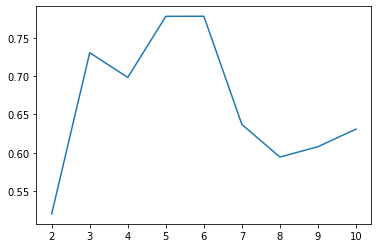

In [324]:
plt.plot(list(range(2,11)),stability_total)

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams
out_path=r'.\output\stability.xlsx'
data=pd.read_excel(out_path)
columns=data.columns.tolist()
columns



['bbcsport_lda',
 'bbcsport_nmf',
 'bbcsport_kmeans',
 'bbcnews_lda',
 'bbcnews_nmf',
 'snippets1_gsdmm',
 'snippets2_gsdmm',
 'agnews_gsdmm',
 'snippets2_seanmf',
 'snippets1_seanmf',
 'agnews_seanmf',
 'reuter_kmeans',
 'reuter_nmf',
 'reuter_lda',
 'bbcnews_kmeans']

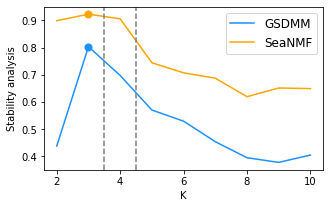

In [17]:
x=list(range(2,11))
y1=data['snippets2_gsdmm'].tolist()
y2=data['snippets2_seanmf'].tolist()
# y3=data['reuter_kmeans'].tolist()

fig = plt.figure(figsize=(5,3))
plt.plot(x,y1,color='dodgerblue')
plt.plot(x,y2,color='orange')
# plt.plot(x,y3,color='greenyellow')

# plt.legend(labels=['LDA','NMF','K-Means'], loc='upper right',prop={'size': 12})
plt.legend(labels=['GSDMM','SeaNMF'], loc='upper right',prop={'size': 12})

plt.xlabel('K',size=10)
plt.ylabel('Stability analysis',size=10)
plt.xticks(size=10)
plt.yticks(size=10)
plt.xticks(list(range(2,12,2)))

plt.scatter(x=3,y=np.max(y1),s=50,color='dodgerblue')
plt.scatter(x=3,y=np.max(y2),s=50,color='orange')
# plt.scatter(x=3,y=np.max(y3),s=50,color='greenyellow')
plt.axvline(x=4.5, color='gray', linestyle='--')  
plt.axvline(x=3.5, color='gray', linestyle='--') 

plt.savefig(r'.\output\snippets2_stability.png',dpi=1000,bbox_inches = 'tight') 